In [2]:
# Basic imports
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.widgets as sw
print(f"SpikeInterface version: {si.__version__}")
from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe, plot_probegroup 
from probeinterface import generate_dummy_probe
from probeinterface import write_probeinterface, read_probeinterface
from probeinterface import write_prb, read_prb

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import glob
import os
import pickle

from scipy.io import loadmat

SpikeInterface version: 0.102.2


In [3]:
BaseDir = glob.glob(os.getcwd()+'/data_demo/*/*/day15')[0]
settingPath = glob.glob(BaseDir+'/settings.xml')[0]
dataPath = glob.glob(BaseDir+'/day15.dat')[0]
chanMapPath = glob.glob(BaseDir+'/chanMap.mat')[0]
print(dataPath)

D:\SpikeSortingPipeline/data_demo\Barrage\FB10\day15/day15.dat


(<matplotlib.collections.PolyCollection at 0x188e74d14d0>, None)

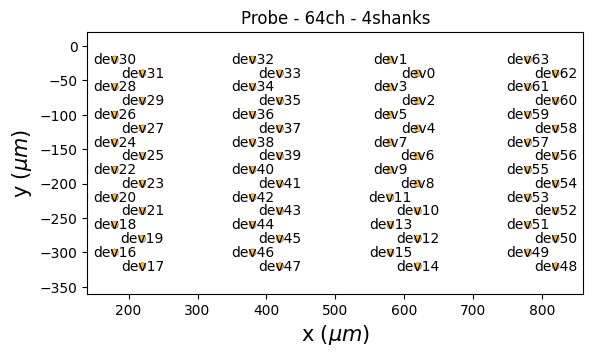

In [4]:
chanMapmat = loadmat(chanMapPath)
x = chanMapmat['xcoords'].flatten()
y = chanMapmat['ycoords'].flatten()
coords = np.column_stack((x, y))
shank_ids = chanMapmat['kcoords'].flatten()
device_ch_inds = chanMapmat['chanMap'].flatten() - 1

probe = Probe(ndim=2, si_units='um')
probe.set_contacts(positions=coords, shapes='circle',
                   shape_params={'radius': 5}, shank_ids=shank_ids)
probe.set_device_channel_indices(device_ch_inds)

# probe_group = ProbeGroup()
# for sid in np.unique(shank_ids):
#     mask = (shank_ids == sid)              
#     sub_probe = probe.get_slice(mask)      
#     probe_group.add_probe(sub_probe)
plot_probe(probe, with_contact_id=True, with_device_index=True)

In [5]:
fs = 20000
recording = se.read_binary(dataPath, sampling_frequency=fs, dtype='int16', num_channels=64, gain_to_uV =0, offset_to_uV=32768 * 0.195)
recording = recording.set_probegroup(probe)
recording.set_channel_groups(shank_ids, channel_ids=None)  
# recording = se.read_binary(dataPath, sampling_frequency=20000, dtype='int16', num_channels=64)

In [5]:

# brain_area_property_values = ['CA1']*32 + ['CA3']*32
# print(brain_area_property_values)

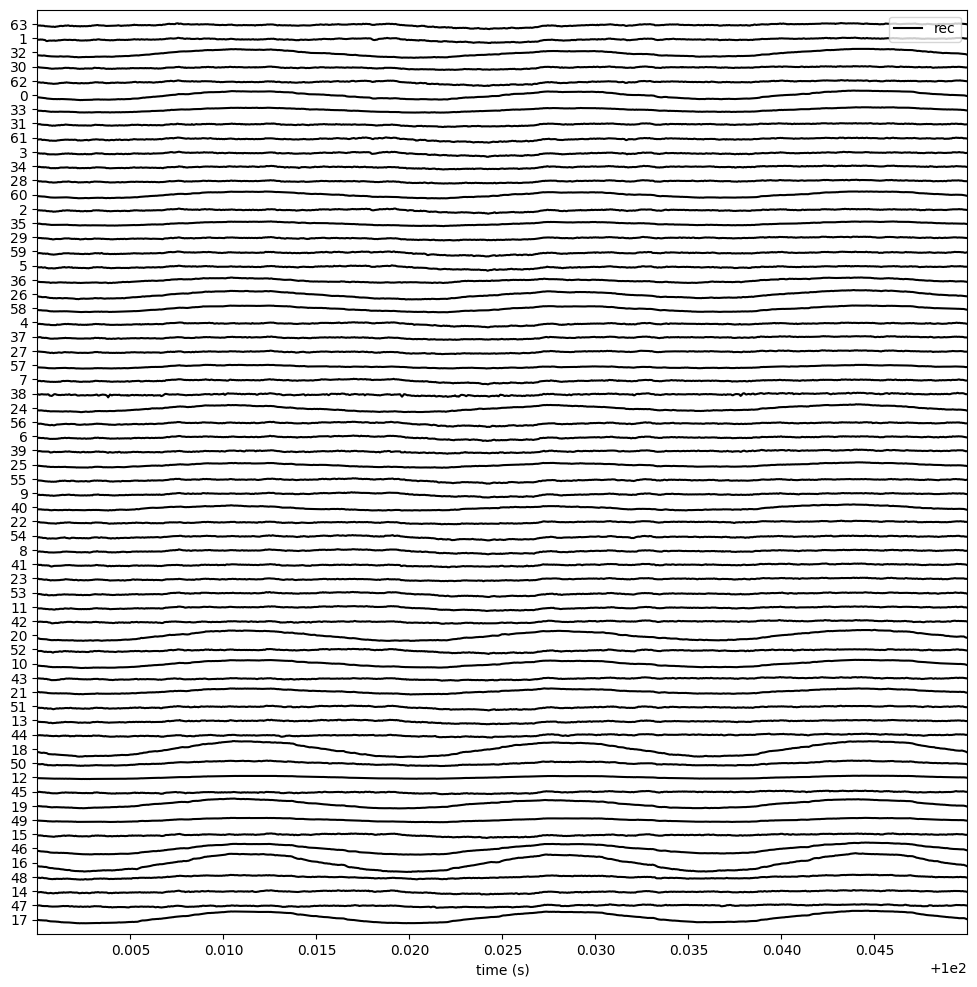

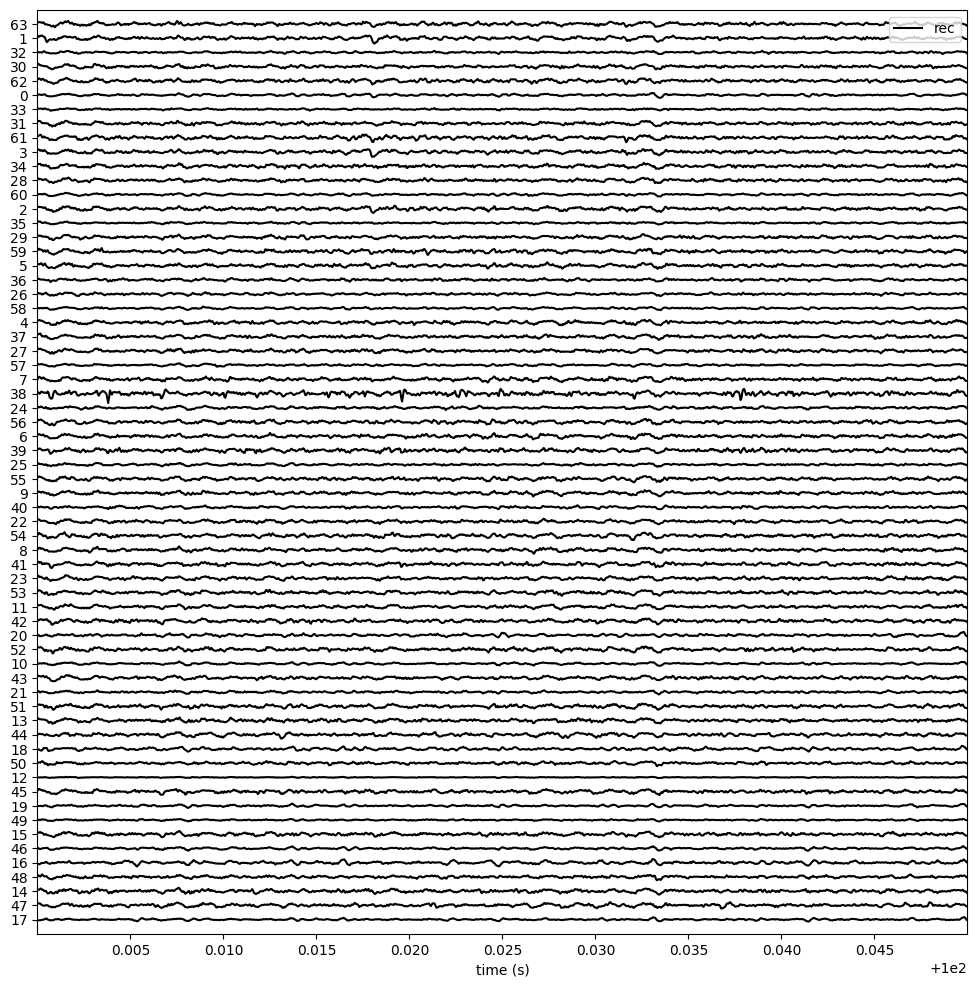

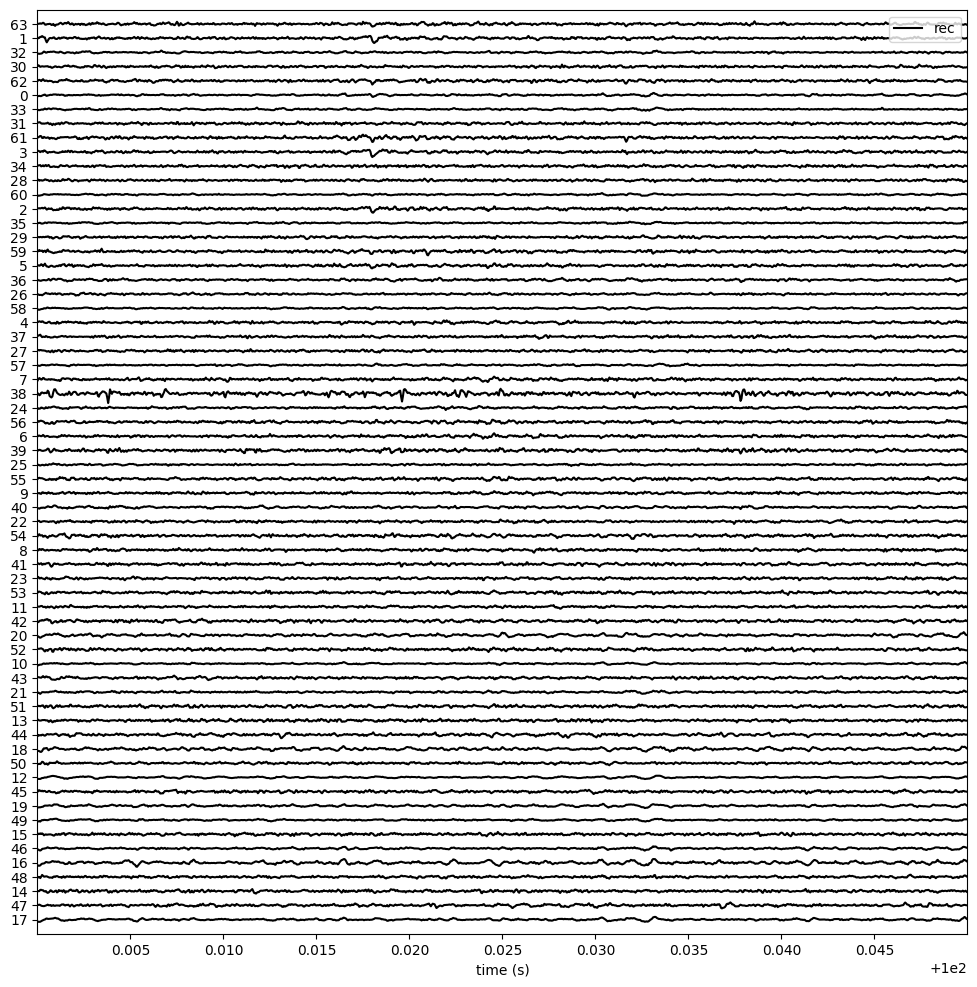

In [9]:
tmin = 100
twind = 0.05
segment_index=0
sw.plot_traces(recording, channel_ids=recording.get_channel_ids() , order_channel_by_depth=True, show_channel_ids=True, time_range=[tmin,tmin+twind], segment_index=segment_index, color_groups=False, figsize=(12, 12))
recording_f = spre.bandpass_filter(recording, freq_min=500, freq_max=8000)
sw.plot_traces(recording_f, channel_ids=recording.get_channel_ids(), order_channel_by_depth=True,show_channel_ids=True, time_range=[tmin,tmin+twind], segment_index=segment_index, color_groups=False, figsize=(12, 12))
# recording_cmr = spre.common_reference(recording_f, reference='local', local_radius=[50,200] , operator='median')
# sw.plot_traces(recording_cmr, channel_ids=recording.get_channel_ids(), order_channel_by_depth=True,show_channel_ids=True, time_range=[tmin,tmin+twind], segment_index=segment_index, color_groups=False, figsize=(12, 12))

recording_cmr = spre.common_reference(recording_f, reference='global' , operator='median')
sw.plot_traces(recording_cmr, channel_ids=recording.get_channel_ids(), order_channel_by_depth=True,show_channel_ids=True, time_range=[tmin,tmin+twind], segment_index=segment_index, color_groups=False, figsize=(12, 12))

In [7]:
[bad_channel_ids, channel_labels] = spre.detect_bad_channels(recording=recording_f, method='coherence+psd') 
print('bad_channel_ids', bad_channel_ids)
print('channel_labels', channel_labels)


C:\Users\aalab\miniforge3\envs\spsort\Lib\site-packages\spikeinterface\preprocessing\detect_bad_channels.py:333: RuntimeWarning: invalid value encountered in divide
  xcorr = np.sum(raw * ref[:, np.newaxis], axis=0) / np.sum(ref**2)


bad_channel_ids []
channel_labels ['good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good']


In [8]:
n_cpus = os.cpu_count()
n_jobs = n_cpus - 2
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="1s", progress_bar=True)

In [9]:
preproc_path = Path(BaseDir) / "preprocessed"
if preproc_path.is_dir():
    recording_saved = si.load(preproc_path)
else:
    recording_saved = recording_cmr.save(folder=BaseDir + "/preprocessed", **job_kwargs)

In [11]:
!python -m kilosort

2025-05-12 18:46:05,798 INFO  - FCI started. Version: 12.4.0.0

2025-05-12 18:46:05,798 INFO  - Completed loading classifications from database

2025-05-12 18:46:05,798 ERROR - Unable to load classification from database with name and id (Classification icon creation failed): Top Secret (67a1a7c8-4696-4313-a9a1-a6c81ee39902)

2025-05-12 18:46:05,799 ERROR - Unable to load classification from database with name and id (Classification icon creation failed): Confidential (b6ddc6cd-4432-4483-87f2-575d4b5247d4)

2025-05-12 18:46:05,799 ERROR - Unable to load classification from database with name and id (Classification icon creation failed): Restricted (5715afa3-e9f8-4026-9db4-92b553167095)

2025-05-12 18:46:05,799 ERROR - Unable to load classification from database with name and id (Classification icon creation failed): Public (9027971d-f9e2-411b-b70e-def3152d56aa)

2025-05-12 18:46:05,801 INFO  - Unable to monitor for Configuration updates because the endpoint service is not currently ser

In [10]:
phydir = BaseDir+'/results_KS4/params.py'
!phy template-gui $phydir

12:11:11.423 [W] model:667            Skipping spike waveforms that do not exist, they will be extracted on the fly from the raw data as needed.


In [14]:
# phydir_KS1 = BaseDir+'/Kilosort_2025-04-24_175843/params.py'
# !phy template-gui $phydir_KS1

In [35]:
sorting_phy = se.PhySortingExtractor(BaseDir+'/results_KS4', exclude_cluster_groups=['noise', 'mua'])
sorting_phy_KS1 = se.PhySortingExtractor(BaseDir+'/Kilosort_2025-04-24_175843_YS', exclude_cluster_groups=['noise', 'mua'])

unit ids : [  9  17  30  31  32  36  44  45  67  83  86  96  97  98  99 103]
unit number : 16


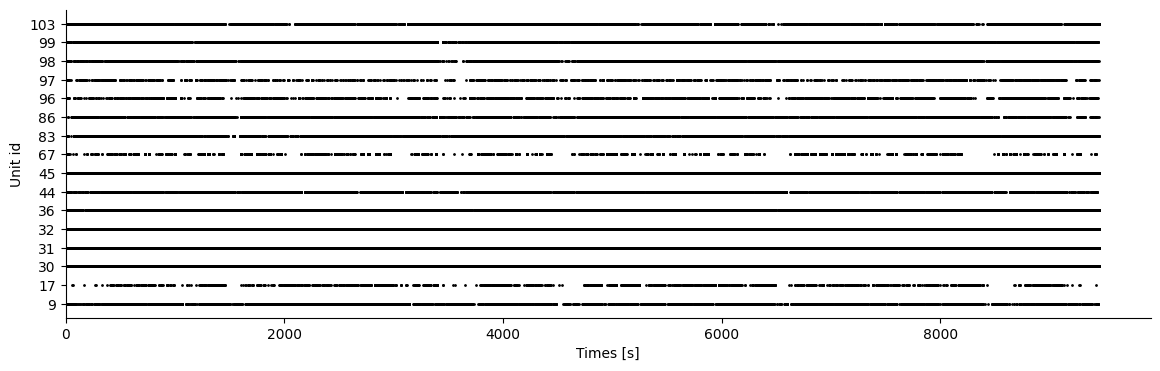

In [36]:
fig=plt.figure(figsize=(14,4))
sw.plot_rasters(sorting_phy, color='k', figure=fig, ax=None);
print(f'unit ids : {sorting_phy.get_unit_ids()}')
print(f'unit number : {len(sorting_phy.get_unit_ids())}')

unit ids : [ 585  595  598  600  760  763  801  809  854  918  953  962  973  986
 1030 1042 1043 1064]
unit number : 18


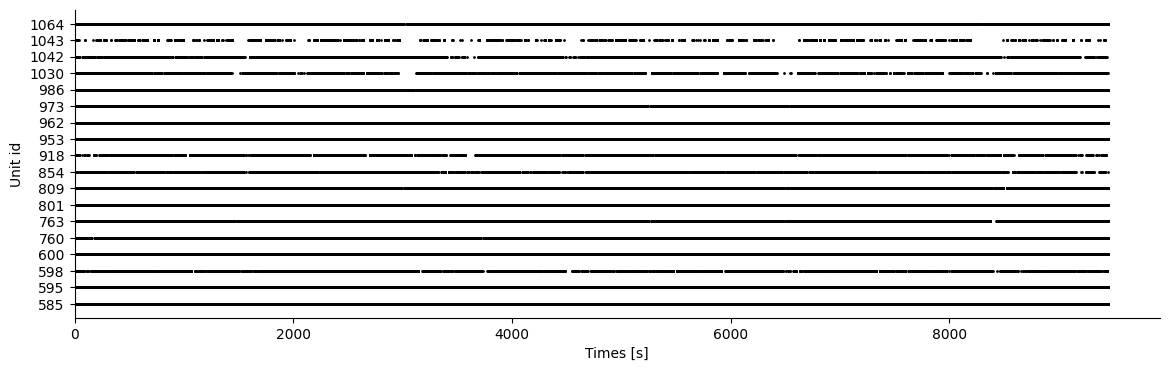

In [37]:
fig=plt.figure(figsize=(14,4))
sw.plot_rasters(sorting_phy_KS1, color='k', figure=fig, ax=None);
print(f'unit ids : {sorting_phy_KS1.get_unit_ids()}')
print(f'unit number : {len(sorting_phy_KS1.get_unit_ids())}')

In [30]:
recording_saved = si.load(preproc_path)

In [31]:
analyzer = si.create_sorting_analyzer(sorting = sorting_phy, recording=recording_saved)
analyzer.compute(['noise_levels','random_spikes','waveforms','templates'])

estimate_sparsity (no parallelization):   0%|          | 0/9451 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms (no parallelization):   0%|          | 0/9451 [00:00<?, ?it/s]

In [33]:
# sw.plot_unit_templates(analyzer)